<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter10SamplingStrategy/DefocusEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Simple defocus parameter estimation
##David Brady
##University of Arizona
##December 2023


This notebook presents a simple neural estimator to evaluate the defocus of images. The PSF is modeled as a gaussian, defocus images are convolved with the Gaussian filter with a blur between 0 and 3 pixels. The defocus paramter is $\frac{\sigma}{3}$, randomly assigned on $[0,1]$.

The neural network consists of 3 convolutional layers with normalization and maxpooling followed by a densely connected layer with linear activation to estimate the defocus.

### Python modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from  scipy.ndimage import gaussian_filter as gf
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model, Sequential
import cv2



# Neural Estimation

## Image database

In [ ]:


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# defocus values
y_train=np.random.random(len(y_train))
y_test=np.random.random(len(y_test))
x_train=np.mean(x_train,axis=3)/255.0
x_test=np.mean(x_test,axis=3)/255.0


In [ ]:
y_test.shape

(10000,)

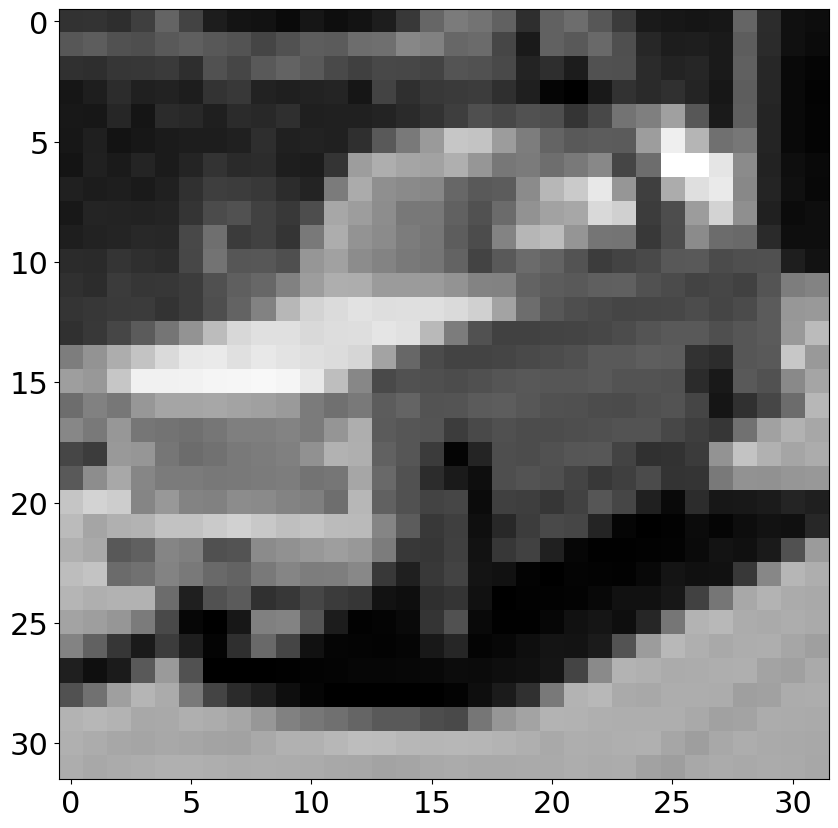

In [ ]:
plt.imshow(x_train[32],cmap='gray')

###  prepare training data

In [ ]:

g_test=np.zeros(np.shape(x_test))
g_train=np.zeros(np.shape(x_train))
for pop in range(np.shape(x_test)[0]):
  g_test[pop,:,:]= gf(x_test[pop,:,:],3*y_test[pop])
for pop in range(np.shape(x_train)[0]):
  g_train[pop,:,:]=gf(x_train[pop,:,:],3*y_train[pop])

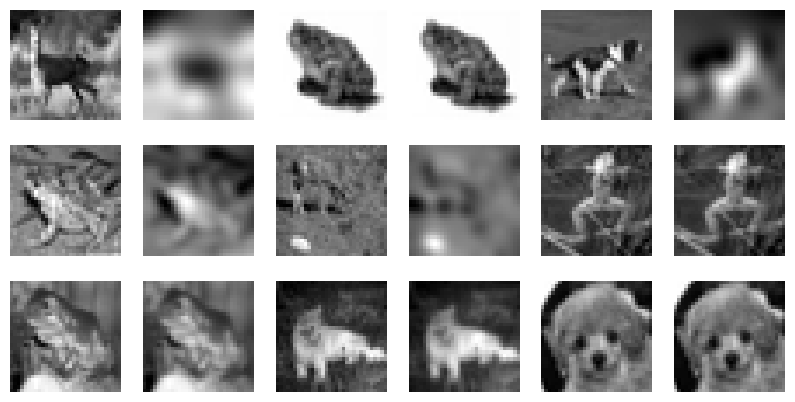

In [ ]:
plt.figure(figsize=(10,5))
images=np.random.randint(0,len(y_train),9)
for pop in range(9):
  plt.subplot(3,6, 2*pop+1)
  plt.imshow(x_train[images[pop]], cmap='gray')
  plt.axis('off')
  plt.subplot(3,6, 2*pop+2)
  plt.imshow(g_train[images[pop]],cmap='gray')
  plt.axis('off')
  plt.savefig('defocusExamples.png')

In [ ]:
g_train = np.reshape(g_train, (len(y_train), 32, 32, 1))
g_test = np.reshape(g_test, (len(y_test), 32, 32, 1))

### Estimation model

In [ ]:
inputs=keras.Input(shape=(32,32,1))

x = layers.Conv2D(16, (5, 5), strides=1, activation="gelu", padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, (4, 4), strides=2, activation="gelu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), strides=2, activation="gelu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="gelu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="linear")(x)

defocus = Model(inputs, outputs)
defocus.compile(optimizer='adam', loss='mean_squared_error')
defocus.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        416       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        4112      
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 16)        64        
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          4640  

### Training

In [ ]:
defocus.fit(
    x=g_train,
    y=y_train,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, y_test),
)

Epoch 1/100
391/391 [==============================] - 16s 8ms/step - loss: 0.8699 - val_loss: 0.1418
Epoch 2/100
391/391 [==============================] - 3s 7ms/step - loss: 0.1373 - val_loss: 0.0342
Epoch 3/100
391/391 [==============================] - 3s 6ms/step - loss: 0.0447 - val_loss: 0.0226
Epoch 4/100
391/391 [==============================] - 3s 7ms/step - loss: 0.0242 - val_loss: 0.0147
Epoch 5/100
391/391 [==============================] - 3s 7ms/step - loss: 0.0187 - val_loss: 0.0101
Epoch 6/100
391/391 [==============================] - 3s 7ms/step - loss: 0.0167 - val_loss: 0.0096
Epoch 7/100
391/391 [==============================] - 3s 6ms/step - loss: 0.0156 - val_loss: 0.0104
Epoch 8/100
391/391 [==============================] - 3s 7ms/step - loss: 0.0147 - val_loss: 0.0070
Epoch 9/100
391/391 [==============================] - 3s 7ms/step - loss: 0.0139 - val_loss: 0.0065
Epoch 10/100
391/391 [==============================] - 3s 7ms/step - loss: 0.0134 - val_l

In [ ]:
defocus.predict(g_test[0:10,:,:,:]).reshape(10)

1/1 [==============================] - 0s 167ms/step


array([0.27051967, 0.3656418 , 0.9350143 , 0.08392179, 0.72627467,
       0.322183  , 0.7407231 , 0.93220735, 0.14900467, 0.07696596],
      dtype=float32)

In [ ]:
y_test[0:10]

array([0.26913183, 0.37055271, 0.95067467, 0.0249277 , 0.73995618,
       0.31619357, 0.82499943, 0.97420385, 0.11684437, 0.04794359])

32/32 [==============================] - 0s 3ms/step


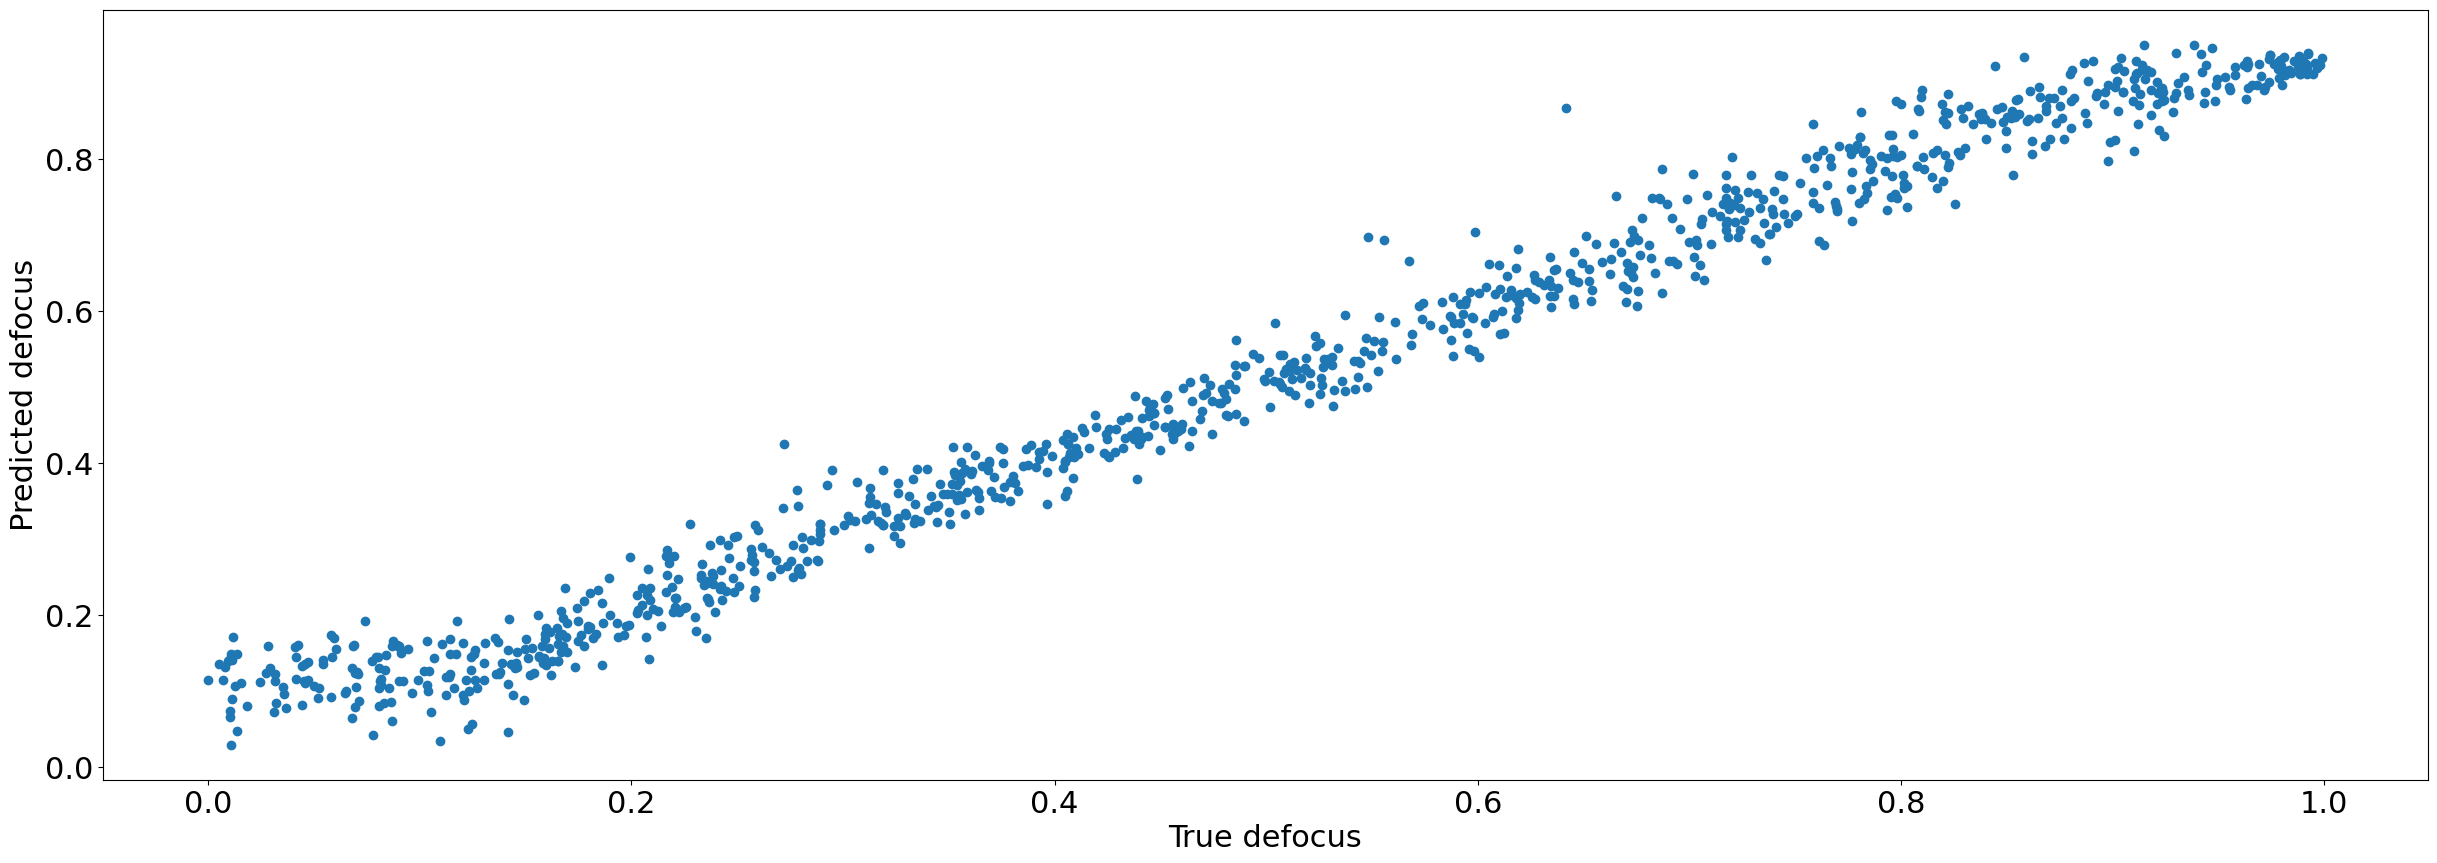

In [ ]:

images=np.random.randint(0,len(y_train),1000)
plt.scatter(y_train[images],defocus.predict(g_train[images,:,:,:]).reshape(1000))
plt.xlabel('True defocus')
plt.ylabel('Predicted defocus')
plt.savefig('defocusAccuracy.png')

## hyperfocal distance vs. focal length

We assume that the circle of confusion is 1 micron*f/#

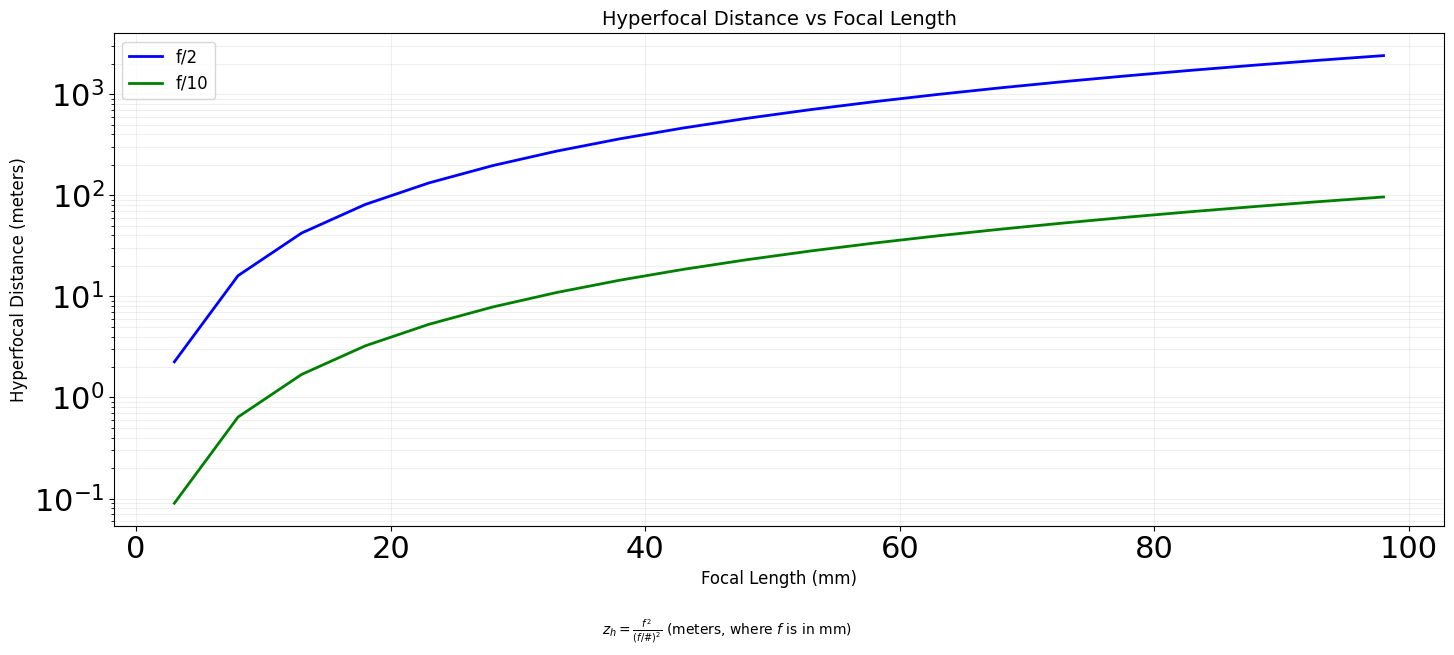

In [5]:

# Define focal lengths from 10mm to 200mm in increments of 10mm
focal_lengths = np.arange(0.003, 0.100, 0.005)

# Calculate hyperfocal distances for f/2 and f/10 (converting to meters)
hyperfocal_f2 = (10**6 * focal_lengths**2 / 2**2)   # in meters
hyperfocal_f10 = (10**6 * focal_lengths**2 / 10**2)  # in meters

# Create the plot
plt.figure(figsize=(15, 7))

# Plot both lines
plt.plot(1000*focal_lengths, hyperfocal_f2, 'b-', linewidth=2, label='f/2')
plt.plot(1000*focal_lengths, hyperfocal_f10, 'g-', linewidth=2, label='f/10')

# Set y-axis to log scale to better visualize the range
plt.yscale('log')

# Add grid
plt.grid(True, which="both", ls="-", alpha=0.2)

# Add labels and title
plt.xlabel('Focal Length (mm)', fontsize=12)
plt.ylabel('Hyperfocal Distance (meters)', fontsize=12)
plt.title('Hyperfocal Distance vs Focal Length', fontsize=14)

# Add legend
plt.legend(loc='best', fontsize=12)

# Add text explaining the formula
formula_text = "$z_h = \\frac{ f^2}{(f/\\#)^2}$ (meters, where $f$ is in mm)"
plt.figtext(0.5, 0.01, formula_text, ha='center', fontsize=10)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

# Optional: Save the figure to a file
# plt.savefig('hyperfocal_distance_plot.png', dpi=300)